In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt    
import numpy as np

In [2]:
train_train_df = pd.read_csv("train_93_95.csv", sep=",")
train_test_df = pd.read_csv("train_96.csv", sep=",")

test_df = pd.read_csv("test.csv", sep=",")

## Random Forest Classifier

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

unwanted_features = ["status", "loan_id"]
features = [x for x in list(train_train_df) if x not in unwanted_features]
target = "status"

X = train_train_df[features]
y = train_train_df[target]

X_test = train_test_df[features]
y_test = train_test_df[target]

rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [100, 150, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8,9,10],
    'criterion' :['gini', 'entropy'],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=4)

CV_rfc.fit(X, y)

print("Best Score:", CV_rfc.best_score_)
print("Best Params:", CV_rfc.best_params_)

Best Score: 0.8908744557329463
Best Params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}


In [10]:
clf_rfc = RandomForestClassifier(random_state=42, criterion='gini', max_depth=8, max_features='auto', n_estimators=100)

clf_rfc.fit(X, y)

RandomForestClassifier(max_depth=8, random_state=42)

AUC Score:  1.0


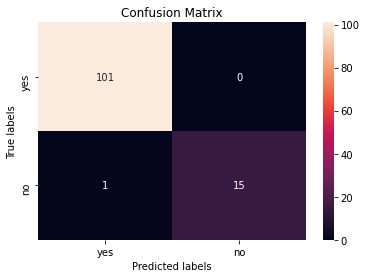

In [11]:
# Predict the response for test dataset
y_pred = clf_rfc.predict_proba(X_test)[:, -1]

# Area Under the Curve, the higher the better
auc = metrics.roc_auc_score(y_test, y_pred)
print("AUC Score: ", auc)

y_pred = np.argmax(clf_rfc.predict_proba(X_test), axis=1)
cm = metrics.confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['yes', 'no']); ax.yaxis.set_ticklabels(['yes', 'no']);

In [12]:
test = test_df[features]

confidences = clf_rfc.predict_proba(test)[:,-1]

confidences = [0 if x < 0.000001 else x for x in confidences]
confidences = ["{:f}".format(x) for x in confidences]

submit = pd.DataFrame()

submit["Id"] = test_df["loan_id"]
submit["Predicted"] = confidences

submit.to_csv("rf_python.csv", sep=",", index=False)

submit

,Id,Predicted
0,4962,0.074600
1,5051,0.128132
2,5207,0.128815
3,5561,0.030106
4,5906,0.071454
...,...,...
349,7242,0.012179
350,7067,0.019302
351,7122,0.731357
352,7221,0.259729


## Neural Network

In [7]:
from keras.models import Sequential
from keras.layers import Dense
import keras

train_train_df = train_train_df.append(train_test_df, ignore_index=True)

X = train_train_df[features]
y = train_train_df[target]

# define the keras model
model = Sequential()
model.add(Dense(15, input_dim=50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC()])
# fit the keras model on the dataset
model.fit(X, y, epochs=300, batch_size=32, verbose=0)
# evaluate the keras model
_, auc = model.evaluate(X, y)
print('AUC: %.2f' % auc)


11/11 [==============================] - 0s 363us/step - loss: 40859.4336 - auc: 0.5255
AUC: 0.53


Instructions for updating:
Please use `model.predict()` instead.
AUC Score:  0.4900990099009901


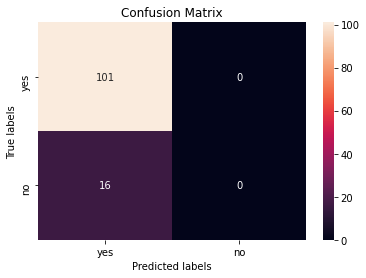

In [8]:
y_pred = model.predict_proba(X_test)

# Area Under the Curve, the higher the better
auc = metrics.roc_auc_score(y_test, y_pred[:,-1])
print("AUC Score: ", auc)

y_pred = np.argmax(model.predict_proba(X_test), axis=1)

cm = metrics.confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['yes', 'no']); ax.yaxis.set_ticklabels(['yes', 'no']);

In [9]:
confidences = model.predict_proba(test)[:,-1]

confidences = [0 if x < 0.000001 else x for x in confidences]
confidences = ["{:f}".format(x) for x in confidences]

submit = pd.DataFrame()

submit["Id"] = test_df["loan_id"]
submit["Predicted"] = confidences

submit.to_csv("neuralnet_python.csv", sep=",", index=False)